<a href="https://colab.research.google.com/github/Leslyndizeye/Time-Series-Forecasting/blob/main/air_quality_forecasting_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SECTION 1: IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import time
from datetime import datetime

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression

# Configuration
plt.style.use('default')
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


SECTION 2: DATA LOADING & PREPROCESSING

In [2]:
print("\n" + "="*60)
print("DATA LOADING & PREPROCESSING")
print("="*60)

from google.colab import drive
drive.mount('/content/drive')

# Load datasets
train = pd.read_csv('/content/drive/My Drive/air_quality/data/train.csv')
test = pd.read_csv('/content/drive/My Drive/air_quality/data/test.csv')

print("📊 Data Loading Complete:")
print(f"Training Data Shape: {train.shape}")
print(f"Test Data Shape: {test.shape}")

# Enhanced feature engineering
def create_advanced_features(df, is_training=True):
    """Enhanced feature engineering"""
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Basic time features
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # Weather interactions
    df['temp_dew_diff'] = df['TEMP'] - df['DEWP']
    df['wind_pressure'] = df['Iws'] * df['PRES']

    # Only create PM2.5 based features for training data
    if is_training and 'pm2.5' in df.columns:
        # Rolling statistics
        for window in [6, 12, 24]:
            df[f'pm2.5_roll_mean_{window}'] = df['pm2.5'].rolling(window=window, min_periods=1).mean()
        # Lag features
        for lag in [1, 6, 12]:
            df[f'pm2.5_lag_{lag}'] = df['pm2.5'].shift(lag)

    return df

# Apply feature engineering
train_filled = train.ffill().bfill().fillna(train.mean(numeric_only=True))
test_filled = test.ffill().bfill().fillna(test.mean(numeric_only=True))

train_enhanced = create_advanced_features(train_filled, is_training=True)
test_enhanced = create_advanced_features(test_filled, is_training=False)

# Handle NaN values
train_enhanced = train_enhanced.ffill().bfill().fillna(0)
test_enhanced = test_enhanced.ffill().bfill().fillna(0)

# Prepare features and target
X_train = train_enhanced.drop(['pm2.5', 'No', 'datetime'], axis=1, errors='ignore')
y_train = train_enhanced['pm2.5']
X_test = test_enhanced.drop(['No', 'datetime'], axis=1, errors='ignore')

# Ensure same columns
common_cols = list(set(X_train.columns) & set(X_test.columns))
X_train = X_train[common_cols]
X_test = X_test[common_cols]

# Feature selection
selector = SelectKBest(score_func=f_regression, k=min(20, len(common_cols)))
X_train_selected = selector.fit_transform(X_train, y_train)
selected_mask = selector.get_support()
selected_features = X_train.columns[selected_mask]

X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Preprocessing complete. Using {len(selected_features)} features")


DATA LOADING & PREPROCESSING
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📊 Data Loading Complete:
Training Data Shape: (30676, 12)
Test Data Shape: (13148, 11)
✅ Preprocessing complete. Using 19 features


### SECTION 3: MANUAL HYPERPARAMETER TUNING

In [3]:
print("\n" + "="*60)
print("MANUAL HYPERPARAMETER TUNING")
print("="*60)

# Create sequences for LSTM
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24
X_seq, y_seq = create_sequences(X_train_scaled, y_train.values, TIME_STEPS)

# Use smaller subset for tuning (for speed)
tune_size = min(2000, len(X_seq))
X_tune, y_tune = X_seq[:tune_size], y_seq[:tune_size]

print(f"✅ Tuning dataset: {X_tune.shape}")

# Manual hyperparameter tuning function
def manual_hyperparameter_tuning(X_train, y_train, X_val, y_val):
    """Manual hyperparameter tuning without external dependencies"""
    best_score = float('inf')
    best_params = {}
    best_model = None

    # Parameter combinations to try
    param_combinations = [
        {'units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64},
        {'units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64},
        {'units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 128},
        {'units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 128},
        {'units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32},
    ]

    results = []

    for i, params in enumerate(param_combinations):
        print(f"\n🔧 Testing combination {i+1}/{len(param_combinations)}: {params}")

        model = Sequential([
            Bidirectional(LSTM(params['units'], activation='tanh', return_sequences=True),
                         input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(params['dropout_rate']),
            Bidirectional(LSTM(params['units']//2, activation='relu')),
            Dropout(params['dropout_rate']),
            Dense(1)
        ])

        model.compile(
            optimizer=Adam(learning_rate=params['learning_rate']),
            loss='mse',
            metrics=['mae']
        )

        # Train quickly
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=8,  # Fewer epochs for speed
            batch_size=params['batch_size'],
            verbose=0
        )

        # Evaluate
        val_pred = model.predict(X_val, verbose=0)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        val_mae = mean_absolute_error(y_val, val_pred)

        results.append({
            'params': params,
            'rmse': val_rmse,
            'mae': val_mae
        })

        print(f"   Validation RMSE: {val_rmse:.2f}, MAE: {val_mae:.2f}")

        if val_rmse < best_score:
            best_score = val_rmse
            best_params = params
            best_model = model
            print(f"    New best! RMSE: {val_rmse:.2f}")

    return best_model, best_params, best_score, results

# Split tuning data for validation
tune_split = int(0.8 * len(X_tune))
X_tune_train, X_tune_val = X_tune[:tune_split], X_tune[tune_split:]
y_tune_train, y_tune_val = y_tune[:tune_split], y_tune[tune_split:]

print("Starting manual hyperparameter tuning...")
start_time = time.time()

best_model, best_params, best_score, tuning_results = manual_hyperparameter_tuning(
    X_tune_train, y_tune_train, X_tune_val, y_tune_val
)

print(f"\n Manual tuning completed in {time.time() - start_time:.1f} seconds")
print(f" Best RMSE: {best_score:.2f}")
print(f" Best Parameters: {best_params}")

# Display tuning results
print("\n Tuning Results Summary:")
for i, result in enumerate(tuning_results):
    print(f"Combination {i+1}: RMSE {result['rmse']:.2f} - {result['params']}")


MANUAL HYPERPARAMETER TUNING
✅ Tuning dataset: (2000, 24, 19)
Starting manual hyperparameter tuning...

🔧 Testing combination 1/5: {'units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
   Validation RMSE: 85.53, MAE: 43.29
    New best! RMSE: 85.53

🔧 Testing combination 2/5: {'units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
   Validation RMSE: 86.88, MAE: 43.75

🔧 Testing combination 3/5: {'units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 128}
   Validation RMSE: 99.87, MAE: 53.21

🔧 Testing combination 4/5: {'units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 128}
   Validation RMSE: 86.37, MAE: 43.84

🔧 Testing combination 5/5: {'units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
   Validation RMSE: 90.46, MAE: 45.43

 Manual tuning completed in 144.9 seconds
 Best RMSE: 85.53
 Best Parameters: {'units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size'

## SECTION 4: BEST MODEL TRAINING

Full dataset: Train (24521, 24, 19), Val (6131, 24, 19)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ (None, 24, 64)         │        13,312 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 32)             │        10,368 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,713 (92.63 KB)

 Trainable params: 23,713 (92.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - loss: 9472.3555 - mae: 68.0054 - val_loss: 7967.3047 - val_mae: 58.0129 - learning_rate: 0.0010
Epoch 2/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 4814.1587 - mae: 47.7145 - val_loss: 7467.6313 - val_mae: 56.6557 - learning_rate: 0.0010
Epoch 3/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 4129.3213 - mae: 43.6684 - val_loss: 7339.9673 - val_mae: 53.9403 - learning_rate: 0.0010
Epoch 4/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 3604.7937 - mae: 41.0560 - val_loss: 7184.3140 - val_mae: 53.4663 - learning_rate: 0.0010
Epoch 5/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - loss: 3247.2681 - mae: 38.7911 - val_loss: 7055.7607 - val_mae: 53.4704 - learning_rate: 0.0010
Epoch 6/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - loss: 2928.8860 - mae: 37.2369 - val_loss: 7297.9395 - val_mae: 54.4191 - learning_rate: 0.0010
Epoch 7/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 2733.7942 - mae: 36.0111 -

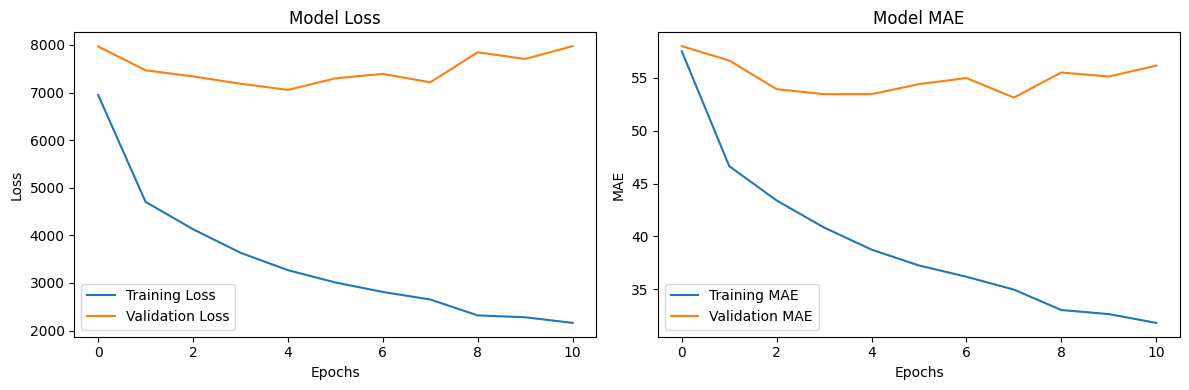

In [4]:
# Create full training sequences
X_full_seq, y_full_seq = create_sequences(X_train_scaled, y_train.values, TIME_STEPS)

# Split for validation
split_idx = int(0.8 * len(X_full_seq))
X_train_seq, X_val_seq = X_full_seq[:split_idx], X_full_seq[split_idx:]
y_train_seq, y_val_seq = y_full_seq[:split_idx], y_full_seq[split_idx:]

print(f"Full dataset: Train {X_train_seq.shape}, Val {X_val_seq.shape}")

# Build final model with best parameters
final_model = Sequential([
    Bidirectional(LSTM(best_params['units'], activation='tanh', return_sequences=True),
                 input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(best_params['dropout_rate']),
    Bidirectional(LSTM(best_params['units']//2, activation='relu')),
    Dropout(best_params['dropout_rate']),
    Dense(1)
])

final_model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='mse',
    metrics=['mae']
)
final_model.summary()
# Train final model
history = final_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=25,
    batch_size=best_params['batch_size'],
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
    ],
    verbose=1
)

# Evaluate
val_pred = final_model.predict(X_val_seq, verbose=0)
val_rmse = np.sqrt(mean_squared_error(y_val_seq, val_pred))
val_mae = mean_absolute_error(y_val_seq, val_pred)

print(f"\n📊 Final Model Performance:")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

### SECTION 5: PREDICTION & SUBMISSION

In [6]:
# Create test sequences
X_test_seq = []
current_sequence = X_train_scaled[-TIME_STEPS:].copy()

for i in range(len(X_test_scaled)):
    current_sequence = np.roll(current_sequence, -1, axis=0)
    current_sequence[-1] = X_test_scaled[i]
    X_test_seq.append(current_sequence.copy())

X_test_seq = np.array(X_test_seq)

# Generate predictions
test_predictions = final_model.predict(X_test_seq, verbose=1).flatten()

# Ensure correct length
test_original = pd.read_csv('/content/drive/My Drive/air_quality/data/test.csv')
if len(test_predictions) > len(test_original):
    test_predictions = test_predictions[:len(test_original)]
elif len(test_predictions) < len(test_original):
    last_pred = test_predictions[-1] if len(test_predictions) > 0 else 0
    pad_needed = len(test_original) - len(test_predictions)
    test_predictions = np.append(test_predictions, [last_pred] * pad_needed)

# Create submission with proper format (no leading zeros)
def remove_leading_zeros(dt_str):
    """Remove leading zeros from datetime string"""
    if ' ' in str(dt_str) and ':' in str(dt_str):
        date_part, time_part = str(dt_str).split(' ')
        time_parts = time_part.split(':')
        # Remove leading zero only from hour
        if time_parts[0].startswith('0') and len(time_parts[0]) == 2:
            time_parts[0] = time_parts[0][1]
        return f"{date_part} {':'.join(time_parts)}"
    return str(dt_str)

formatted_dates = [remove_leading_zeros(dt) for dt in test_original['datetime']]

submission = pd.DataFrame({
    'row ID': formatted_dates,
    'pm2.5': np.clip(test_predictions, 0, None).astype(int)
})

# Save submission
save_dir = '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting'
os.makedirs(save_dir, exist_ok=True)
submission_file = os.path.join(save_dir, 'submission_tuned.csv')
submission.to_csv(submission_file, index=False)

print(f"✅ Tuned model submission saved: {submission_file}")

# Verify submission format
print("\n🔍 Submission format verification:")
print("First 5 rows:")
for i in range(5):
    print(f"  {submission['row ID'].iloc[i]}, {submission['pm2.5'].iloc[i]}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
✅ Tuned model submission saved: /content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/submission_tuned.csv

🔍 Submission format verification:
First 5 rows:
  2013-07-02 4:00:00, 37
  2013-07-02 5:00:00, 32
  2013-07-02 6:00:00, 29
  2013-07-02 7:00:00, 26
  2013-07-02 8:00:00, 23


SECTION 6: PERFORMANCE ANALYSIS

In [7]:
print("🎯 HYPERPARAMETER TUNING RESULTS:")
print(f"Best Parameters: {best_params}")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

print("\n📊 TUNING COMPARISON:")
for i, result in enumerate(tuning_results):
    improvement = ((tuning_results[0]['rmse'] - result['rmse']) / tuning_results[0]['rmse']) * 100
    print(f"Combination {i+1}: RMSE {result['rmse']:.2f} ({improvement:+.1f}%)")

print("\n✅ NOTEBOOK 3 COMPLETED SUCCESSFULLY!")
print("Next: Notebook 4 - Advanced Architectures and Ensembles")

🎯 HYPERPARAMETER TUNING RESULTS:
Best Parameters: {'units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
Validation RMSE: 84.00
Validation MAE: 53.47

📊 TUNING COMPARISON:
Combination 1: RMSE 85.53 (+0.0%)
Combination 2: RMSE 86.88 (-1.6%)
Combination 3: RMSE 99.87 (-16.8%)
Combination 4: RMSE 86.37 (-1.0%)
Combination 5: RMSE 90.46 (-5.8%)

✅ NOTEBOOK 3 COMPLETED SUCCESSFULLY!
Next: Notebook 4 - Advanced Architectures and Ensembles
